In [ ]:
import sys
sys.path.append("../")  # path contains python_file.py

In [2]:
import iris
import numpy as np
import scipy.stats

In [3]:
%load_ext autoreload
%autoreload 2

# Testing data ISIMIP

In [4]:
def read_in_and_preprocess_isimip_testing_data(variable, grid_point = [0,0]):
    obs = np.array(iris.load_cube("testing_data/ISIMIP/"+variable+"_obs-hist_coarse_1979-2014.nc").data)
    cm_hist = np.array(iris.load_cube("testing_data/ISIMIP/"+variable+"_sim-hist_coarse_1979-2014.nc").data)
    cm_future = np.array(iris.load_cube("testing_data/ISIMIP/"+variable+"_sim-fut_coarse_2065-2100.nc").data)
    
    obs = np.moveaxis(obs, -1, 0)
    cm_hist = np.moveaxis(cm_hist, -1, 0)
    cm_future = np.moveaxis(cm_future, -1, 0)

    obs = obs[:,  grid_point[0], grid_point[1]]
    cm_hist = cm_hist[:,  grid_point[0], grid_point[1]]
    cm_future = cm_future[:,  grid_point[0], grid_point[1]]
    
    return obs, cm_hist, cm_future

variables = ['hurs', 'pr', 'prsnratio', 'psl', 'rsds', 'sfcWind', 'tas', 'tasrange', 'tasskew']

# Comparison ISIMIP and PACKAGE_NAME

In [5]:
from PACKAGE_NAME.debias import ISIMIP
import PACKAGE_NAME.code_isimip.utility_functions as uf
from PACKAGE_NAME.code_isimip.bias_adjustment import adjust_bias_one_month, map_quantiles_parametric_trend_preserving

## Step 5: pseudo future observations

In [6]:
obs, cm_hist, cm_future = read_in_and_preprocess_isimip_testing_data("tas")

debiaser = ISIMIP.from_variable(variable="tas")
debiaser

ISIMIP(distribution=<scipy.stats._continuous_distns.norm_gen object at 0x7f7c8901fee0>, trend_preservation_method='additive', detrending=True, reasonable_physical_range=[0, 400], variable='tas', lower_bound=-inf, lower_threshold=-inf, upper_bound=inf, upper_threshold=inf, trend_removal_with_significance_test=True, trend_transfer_only_for_values_within_threshold=True, event_likelihood_adjustment=False, ecdf_method='linear_interpolation', iecdf_method='linear', running_window_mode=True, running_window_length=31, running_window_step_length=1)

In [7]:
future_observations = debiaser.step5(obs, cm_hist, cm_future)
future_observations_isimip = uf.map_quantiles_non_parametric_trend_preserving(
    x_obs_hist = obs, x_sim_hist = cm_hist, x_sim_fut = cm_future, 
    trend_preservation = debiaser.trend_preservation_method, 
    n_quantiles = min(obs.size, cm_hist.size, cm_future.size)-1,
    max_change_factor = 100., max_adjustment_factor = 9.,
    adjust_obs = True, 
    lower_bound = None if np.isinf(debiaser.lower_bound) else debiaser.lower_bound,
    upper_bound = None if np.isinf(debiaser.upper_bound) else debiaser.upper_bound
)

print(sum(np.isclose(future_observations, future_observations_isimip))/cm_future.size)
print(np.max(np.abs(future_observations - future_observations_isimip)))
print(np.mean(np.abs(future_observations - future_observations_isimip)))

0.9793885001521144
0.02037198862541345
0.0005858738172709933


It seems that ISIMIP and own implementation are in relative agreement regarding the generated pseudo-future observations. Small deviations exist which are probably due to the way ISIMIP computes the inverse cdf:

```python
from PACKAGE_NAME.code_isimip.utility_functions import percentile1d
x_obs_hist = obs
x_sim_hist = cm_hist
x_sim_fut = cm_future

n_quantiles = min(obs.size, cm_hist.size, cm_future.size)-1
n = min([n_quantiles + 1, x_obs_hist.size, x_sim_hist.size, x_sim_fut.size])
p_zeroone = np.linspace(0., 1., n)

# compute quantiles of input data
q_obs_hist = percentile1d(x_obs_hist, p_zeroone)
q_sim_hist = percentile1d(x_sim_hist, p_zeroone)
q_sim_fut = percentile1d(x_sim_fut, p_zeroone)

# compute quantiles needed for quantile delta mapping
p = np.interp(x_obs_hist, q_obs_hist, p_zeroone)
F_sim_fut_inv  = np.interp(p, p_zeroone, q_sim_fut)
F_sim_hist_inv = np.interp(p, p_zeroone, q_sim_hist)
F_obs_hist_inv = np.interp(p, p_zeroone, q_obs_hist)
y = F_obs_hist_inv + F_sim_fut_inv - F_sim_hist_inv

```

The double interpolation in `p = np.interp(obs, q_obs_hist, p_zeroone)` and `F_sim_fut_inv  = np.interp(p, p_zeroone, q_sim_fut)`sometimes introduces artifacts and leads to different results than the more straightforward: 

```python
from PACKAGE_NAME.math_helpers import ecdf, iecdf

obs_hist = obs

# Compute p = F_obs_hist(x) with x in obs_hist
p = ecdf(obs_hist, obs_hist, n = n)

# Compute q-vals: q = IECDF(p)
q_obs_hist = obs_hist  # TODO: = iecdf_obs_hist(p), appears in eq. 7
q_cm_future = iecdf(cm_future, p, method=debiaser.iecdf_method)
q_cm_hist = iecdf(cm_hist, p, method=debiaser.iecdf_method)
```

The values in our `p` and ISIMIP's ones agree and the inverses up to a small difference.


### Methodical comparison: bring to work later

## Step 6: Quantile transfer

First: work with future observations from ISIMIP in step5 and run them through step6.

In [8]:
from PACKAGE_NAME.code_isimip.bias_adjustment import adjust_bias_one_month, map_quantiles_parametric_trend_preserving
import PACKAGE_NAME.code_isimip.utility_functions as uf

obs, cm_hist, cm_future = read_in_and_preprocess_isimip_testing_data("tas")
debiaser = ISIMIP.from_variable(variable="tas")

future_observations_isimip = uf.map_quantiles_non_parametric_trend_preserving(
    x_obs_hist = obs, x_sim_hist = cm_hist, x_sim_fut = cm_future, 
    trend_preservation = debiaser.trend_preservation_method, 
    n_quantiles = min(obs.size, cm_hist.size, cm_future.size)-1,
    max_change_factor = 100., max_adjustment_factor = 9.,
    adjust_obs = True, 
    lower_bound = None if np.isinf(debiaser.lower_bound) else debiaser.lower_bound,
    upper_bound = None if np.isinf(debiaser.upper_bound) else debiaser.upper_bound
)

step6_using_isimip_obs_future = debiaser.step6(obs, future_observations_isimip, cm_hist, cm_future)
isimip_mapping = map_quantiles_parametric_trend_preserving(
    x_obs_hist = obs, x_sim_hist = cm_hist, x_sim_fut = cm_future, 
    distribution = "normal", 
    trend_preservation = debiaser.trend_preservation_method, 
    adjust_p_values=debiaser.event_likelihood_adjustment,
    lower_bound = None if np.isinf(debiaser.lower_bound) else debiaser.lower_bound,
    lower_threshold = None if np.isinf(debiaser.lower_threshold) else debiaser.lower_threshold,
    upper_bound = None if np.isinf(debiaser.upper_bound) else debiaser.upper_bound,
    upper_threshold = None if np.isinf(debiaser.upper_threshold) else debiaser.upper_threshold,
    unconditional_ccs_transfer = debiaser.trend_transfer_only_for_values_within_threshold,
    trendless_bound_frequency = False, #???
    n_quantiles = min(obs.size, cm_hist.size, cm_future.size)-1,
    p_value_eps=1e-10,
    max_change_factor=100.0,
    max_adjustment_factor=9.0
)



print(np.max(np.abs(step6_using_isimip_obs_future-isimip_mapping)))
print(np.sum(np.isclose(step6_using_isimip_obs_future, isimip_mapping))/isimip_mapping.size)

0.0
1.0


At least for tas ISIMIP and mine results are in agreement. TODO: check other options. Only thing that influences the results is n_quantiles determining the size of the ISIMIP-grid for computing quantiles. If it is smaller then deviations get larger

# Full comparison

In [9]:
from PACKAGE_NAME.code_isimip.bias_adjustment import adjust_bias_one_month

obs, cm_hist, cm_future = read_in_and_preprocess_isimip_testing_data("tas", grid_point=[0,0])
debiaser = ISIMIP.from_variable(variable="tas")

isimip_adjustment = adjust_bias_one_month(
    data = {'obs_hist': [obs], 'sim_hist': [cm_hist], 'sim_fut': [cm_future]},
    years = {'obs_hist': np.repeat(np.arange(1979, 2015), 366)[:obs.size], 'sim_hist': np.repeat(np.arange(1979, 2015), 366)[:cm_hist.size], 'sim_fut': np.repeat(np.arange(2065, 2101), 366)[:cm_future.size]},
    long_term_mean = {'obs_hist' : [obs.mean()], 'sim_hist' : [cm_hist.mean()], 'sim_fut' : [cm_future.mean()]},
    lower_bound = [None if np.isinf(debiaser.lower_bound) else debiaser.lower_bound],
    lower_threshold = [None if np.isinf(debiaser.lower_threshold) else debiaser.lower_threshold],
    upper_bound = [None if np.isinf(debiaser.upper_bound) else debiaser.upper_bound],
    upper_threshold = [None if np.isinf(debiaser.upper_threshold) else debiaser.upper_threshold],
    unconditional_ccs_transfer=[debiaser.trend_transfer_only_for_values_within_threshold],
    trendless_bound_frequency=[False],
    randomization_seed=None,
    detrend=[False],#debiaser.detrending],
    rotation_matrices=[],
    n_quantiles=min(obs.size, cm_hist.size, cm_future.size)-1,
    distribution=["normal"],
    trend_preservation=[debiaser.trend_preservation_method],
    adjust_p_values=[debiaser.event_likelihood_adjustment],
    invalid_value_warnings=True
)[0]

debiaser.detrending = False
my_adjustment = debiaser._apply_on_window(obs, cm_hist, cm_future)

In [10]:
np.sum(np.isclose(isimip_adjustment, my_adjustment))/my_adjustment.size

1.0

In [11]:
np.max(np.abs(isimip_adjustment - my_adjustment))

9.1552734e-05

Without detrending my results are exactly the same as isimips. Look at it on a monthly basis:

In [12]:
from cf_units import num2date

def get_dates(x):
    time_dimension = x.coords()[2]
    dates = time_dimension.units.num2date(time_dimension.points)
    return dates

In [13]:
def read_in_and_preprocess_isimip_testing_data_with_dates(variable, grid_point = [0,0]):
    
    obs = iris.load_cube("testing_data/ISIMIP/"+variable+"_obs-hist_coarse_1979-2014.nc")
    cm_hist = iris.load_cube("testing_data/ISIMIP/"+variable+"_sim-hist_coarse_1979-2014.nc")
    cm_future = iris.load_cube("testing_data/ISIMIP/"+variable+"_sim-fut_coarse_2065-2100.nc")

    dates = {
        "obs": get_dates(obs),
        "cm_hist": get_dates(cm_hist),
        "cm_future": get_dates(cm_future)
    }
    
    obs = np.array(obs.data)
    cm_hist = np.array(cm_hist.data)
    cm_future = np.array(cm_future.data)

    
    obs = np.moveaxis(obs, -1, 0)
    cm_hist = np.moveaxis(cm_hist, -1, 0)
    cm_future = np.moveaxis(cm_future, -1, 0)

    obs = obs[:,  grid_point[0], grid_point[1]]
    cm_hist = cm_hist[:,  grid_point[0], grid_point[1]]
    cm_future = cm_future[:,  grid_point[0], grid_point[1]]
    
    return obs, cm_hist, cm_future, dates

In [14]:
def day(x):
    return x.day

def month(x):
    return x.month

def year(x):
    return x.year

day = np.vectorize(day)
month = np.vectorize(month)
year = np.vectorize(year)


In [64]:
from PACKAGE_NAME.code_isimip.bias_adjustment import adjust_bias_one_month
from PACKAGE_NAME.utils import day_of_year

obs, cm_hist, cm_future, dates = read_in_and_preprocess_isimip_testing_data_with_dates("tas")
debiaser = ISIMIP.from_variable(variable="tas")
debiaser.iecdf_method = "linear"

obs_jan = obs[month(dates["obs"]) == 1]
cm_hist_jan = cm_hist[month(dates["cm_hist"]) == 1]
cm_future_jan = cm_future[month(dates["cm_future"]) == 1]

isimip_adjustment = adjust_bias_one_month(
    data = {'obs_hist': [obs_jan], 'sim_hist': [cm_hist_jan], 'sim_fut': [cm_future_jan]},
    years = {
        'obs_hist': year(dates["obs"])[month(dates["obs"]) == 1], 
        'sim_hist': year(dates["cm_hist"])[month(dates["cm_hist"]) == 1], 
        'sim_fut': year(dates["cm_future"])[month(dates["cm_future"]) == 1]
    },
    long_term_mean = {'obs_hist' : [obs.mean()], 'sim_hist' : [cm_hist.mean()], 'sim_fut' : [cm_future.mean()]},
    lower_bound = [None if np.isinf(debiaser.lower_bound) else debiaser.lower_bound],
    lower_threshold = [None if np.isinf(debiaser.lower_threshold) else debiaser.lower_threshold],
    upper_bound = [None if np.isinf(debiaser.upper_bound) else debiaser.upper_bound],
    upper_threshold = [None if np.isinf(debiaser.upper_threshold) else debiaser.upper_threshold],
    unconditional_ccs_transfer=[not debiaser.trend_transfer_only_for_values_within_threshold],
    trendless_bound_frequency=[False],
    randomization_seed=None,
    detrend=[debiaser.detrending],
    rotation_matrices=[],
    n_quantiles=min(obs_jan.size, cm_hist_jan.size, cm_future_jan.size)-1,
    distribution=["normal"],
    trend_preservation=[debiaser.trend_preservation_method],
    adjust_p_values=[debiaser.event_likelihood_adjustment],
    invalid_value_warnings=True
)[0]
#debiaser.detrending = False
my_adjustment = debiaser._apply_on_window(
    obs_jan, 
    cm_hist_jan, 
    cm_future_jan, 
    year(dates["obs"])[month(dates["obs"]) == 1], 
    year(dates["cm_hist"])[month(dates["cm_hist"]) == 1], 
    year(dates["cm_future"])[month(dates["cm_future"]) == 1]
)

np.sum(np.isclose(isimip_adjustment, my_adjustment))/my_adjustment.size


0.9973118279569892

In [65]:
np.max(np.abs(isimip_adjustment-my_adjustment))

1.0876465

In [66]:
isimip_adjustment[330]

260.46756

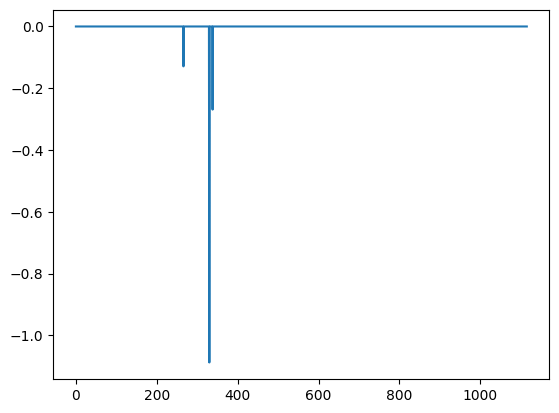

In [67]:
import matplotlib.pyplot as plt
diff = isimip_adjustment-my_adjustment
plt.plot(list(range(diff.size)), diff)
plt.show()

In [27]:
debiaser

ISIMIP(distribution=<scipy.stats._continuous_distns.norm_gen object at 0x7f7c8901fee0>, trend_preservation_method='additive', detrending=True, reasonable_physical_range=[0, 400], variable='tas', lower_bound=-inf, lower_threshold=-inf, upper_bound=inf, upper_threshold=inf, trend_removal_with_significance_test=True, trend_transfer_only_for_values_within_threshold=True, event_likelihood_adjustment=False, ecdf_method='linear_interpolation', iecdf_method='linear', running_window_mode=True, running_window_length=31, running_window_step_length=1)

If I run it only on january the results are equal also with detrending. 

Open issues:
- Iteration over month and how do we pass time to ISIMIP-apply function (used for month-iteration and detrending to group together years) + how to implement the running window mode if no time was passed to the apply-function, but also if it is passed (then we can still group together years for both window and detrending if passed):
    - Can add different optional arguments like months = {"obs": [], "cm_hist": []}, or bigger months_obs, months_cm_hist, etc. time_obs, time_cm_hist (then what time-format?), year_obs, year_cm_hist --> form as much time-information as we can get out of that. What is most useful and comfortable for user.
    - Show equivalence with ISIMIP-implementation.
    - Is time used somewhere else other than to define iteration-periods and detrending? I don't think so, but check!
- Lot's of ISIMIP options and versions. What do we take as parameter and how do we structure initalisation?
    - Do we want to offer version-selection or just implement v2.5? If we want to offer that: what do we need to add as parameters
    - Code-proposal: dataclass and fromn_variable option for each debiaser. Is that useful? How do we construct a debiaser?
    - Concrete questions/isimip-options: 
        - One still unclear ISIMIP-option
        - p-value thresholding as option? Or implemented fixed
        - add option to pass year or date generally?
- Do we want each debiaser as dataclass with a normal init-method and one from_variable one or is init alright. Could for example change linear scaling to a dataclass that can be initialised with scaling-method and from_variable one.
- Is dataclass the correct type because it is not about arbitrary data but about complicated configs.
 
TODO:
- Do we want to have ISIMIP-modes?
 

Things that are different in different ISIMIP-versions: 
- "trend_removal_with_significance_test": True,  # >= v2.1, step 3
- "powerlaw_exponent_step4": 1,  # >= v2.2: uniform distribution, step 4
- "pseudo_future_observations_bounded_variables": "v2.3",  # >= v2.3: new equation, step 5
- "trend_transfer_only_for_values_within_threshold": True,  # >= v2.4,  step 5
- which equation is used for getting the bounds in step6
- which variables are affected by detrending
- for which variables the event likelihood is adjusted
- running window mode with params (v2.5)
- lots of chaos happening with hurs (not entirely sure what is going on there?)
- stuff I missed


what do we need options for?

- trend_removal_with_significance_test
- trend_transfer_only_for_values_within_threshold
- running window mode
- variable options:
    -   "lower_bound": 0,
        "lower_threshold": 0.01,
        "upper_bound": 100,
        "upper_threshold": 99.99,
        "distribution": scipy.stats.beta,
        "trend_preservation_method": "bounded",
        "detrending": False,
        "event_likelihood_adjustment": False,  # >= v2.5 step 6

I would argue we can kick out:
    - powerlaw exponent
    - equation used for getting hte bounds in step6
  



# Datetime passing

We need datetimes in python datetime format (or any other format having .month, .day and .year attributes). A numpy datetime64 can be easily converted using:

```python
datetime64Obj = np.datetime64('2002-07-04T02:55:41-0700')
print datetime64Obj.astype(object).year
```

In [19]:
obs, cm_hist, cm_future, dates = read_in_and_preprocess_isimip_testing_data_with_dates("tas")
debiaser = ISIMIP.from_variable(variable="tas")
debiaser.running_window_mode = False

my_adjustment = debiaser.apply_location(obs, cm_hist, cm_future, *dates.values())
my_adjustment

array([265.71384, 265.77286, 266.56177, ..., 281.1639 , 278.05957,
       277.32367], dtype=float32)

In [20]:
obs, cm_hist, cm_future, dates = read_in_and_preprocess_isimip_testing_data_with_dates("tas")
debiaser = ISIMIP.from_variable(variable="tas")
debiaser.running_window_mode = True

my_adjustment = debiaser.apply_location(obs, cm_hist, cm_future, *dates.values())


In [21]:
from PACKAGE_NAME.debias import ISIMIP

my_adjustment = debiaser.apply_location(obs, cm_hist, cm_future)


                    ISIMIP runs in running window mode without time-information.
                    A standard length of 365 days is assumed for the year and observations are chunked using this.
                    This can lead to slight numerical differences due to leap years
                    


In [22]:
my_adjustment

array([263.99503, 264.0593 , 264.91815, ..., 281.4761 , 277.96683,
       277.13495], dtype=float32)